# NEU502B Homework 5
*Due April 15, 2024*

*Submission instructions:* First, rename your homework notebook to include your name (e.g. `homework-5-nastase.ipynb`); keep your homework notebook in the `homework` directory of your clone of the class repository. Prior to submitting, restart the kernel and run all cells (see *Kernel* > *Restart Kernel and Run All Cells...*) to make sure your code runs and the figures render properly. Only include cells with necessary code or answers; don't include extra cells used for troubleshooting. To submit, `git add`, `git commit`, and `git push` your homework to your fork of the class repository, then make a pull request on GitHub to sync your homework into the class repository.

In the first homework assignment, we explored how a system can extract latent structure in sensory stimuli (e.g. natural scenes) using unsupervised learning algorithms like Hebbian learning. Our model was shown a set of images with no final goal specified, nor any expectations with which to compare its performance throughout learning. Now, we're interested in how a system can learn to reach a goal through interactions with its environment, by maximizing rewards or minimizing penalties.

Reinforcement learning (RL) models solve problems by maximizing some operationalization of reward. These models use goal-directed learning to solve closed-loop problems: present actions influence the environment, thus changing the circumstances of future actions toward the same goal. In RL, we hope to discover the actions that increase chances of rewards within specific states in the environment.

<img src="model.png" width="400">  

An agent must be able to sense the state of the environment either fully or partially, and its actions must be able to change this state. Consider the following example from Sutton and Barto (1992):
> "Phil prepares his breakfast. Closely examined, even this apparently mundane activity reveals a complex web of conditional behavior and interlocking goal-subgoal relationships: walking to the cupboard, opening it, selecting a cereal box, then reaching for, grasping, and retrieving the box. Other complex, tuned, interactive sequences of behavior are required to obtain a bowl, spoon, and milk jug. Each step involves a series of eye movements to obtain information and to guide reaching and locomotion. Rapid judgments are continually made about how to carry the objects or whether it is better to ferry some of them to the dining table before obtaining others. Each step is guided by goals, such as grasping a spoon or getting to the refrigerator, and is in service of other goals, such as having the spoon to eat with once the cereal is prepared and ultimately obtaining nourishment."

At each point in time, there is a state-action pair. Some of them fall under sub-goals, while others could ultimately be a state where there is a high chance of reward, fulfilling the goal of feeding. To be able to model this process, we have to break it down into its interacting components: 
- The agent has a policy, the map between perceived states and the actions taken. We can think of it as a set of stimulus-response rules or associations that determine behavior given a state and a goal within the environment. It can be implemented through the probabilities of taking specific actions given a state. 
- This set of rules should serve to maximize the reward signal in the short and/or long term. 
- Environmental states are evaluated through a value function, which provides a measure of the expected rewards that can be obtained moving forward from a specific state. Grabbing a bowl might not feed you immediately, yet it has high value as it will lead you to a state in which you can feed yourself some cereal without spilling milk all over the table. Would grabbing a shallow dish instead of a bowl have the same value? Actions are taken based on these value judgements. 
- The agent could have the ability for foresight and planning if it has a model of the environment. This means it can have a model of how the environment reacts to its behavior, from which to base its strategies and adjustments.

At each decision, the agent has a choice to either exploit the actions it has already tested to be effective, or it can explore the action-state space to find new routes to optimal rewards. Exploration is risky, yet under some circumstances it will pay off in the long run. Finding the balance between the two would be the optimal solution in uncertain environments. Different methods can be employed to deal with this duality:
- On-policy methods improve the policy that is used to make decisions. This policy is generally soft (probabilistic), as $P(s∈S,a∈A│s)>0$, where $S$ is the possible states and $A|s$ is the possible actions given a state. The probability is gradually shifted to a deterministic optimal policy with each update. For example, $\epsilon-greedy$ policies choose an action that has maximal expected value most of the time (with probability 1 – a small number $\epsilon$). However, with probability $\epsilon$ the agent will choose an action at random. The agent will try to learn values based on subsequent optimal behavior, yet it has to behave non-optimally (choosing random actions) in order to explore and find the optimal actions. This means the agent has to learn about the optimal policy while behaving according to an exploratory policy. On-policy can be thought of as a compromise, where values are learned for a near optimal policy that still explores. 
- Another approach is to use two policies, a target policy and a behavior policy. The first one is modified based on the information that is collected through the behaviors generated by the second. This approach is termed off-policy, as learning occurs based on behaviors generated off the policy being developed. The benefit here is that the target policy can be deterministic (i.e. greedy), while the behavior policy can continue to explore without limits.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### Problem 1: Fitting RL models to data

First, familiarize yourself with the two-step RL task ([Daw et al., 2011](https://doi.org/10.1016/j.neuron.2011.02.027)). Visit this website to play through an example of the two-step RL task: https://nivlab.github.io/jspsych-demos/tasks/two-step/experiment.html. If you're interested, the Python code for the task can be found at: https://github.com/nivlab/jspsych-demos/tree/main/tasks/two-step.
    
The data from the two-step task are structured as follows:
- **choice1**: your choices at the first level (1 or 2)
- **choice2**: your choices at the second level (1 or 2)
- **state**: which second level game you were offered on this trial 
    - choice1 = 1 at the first level (S1) leads to S2 in approximately 70% of the trials
    - choice1 = 2 at the first level (S1) leads to S3 in approximately 70% of the trials
- **money**: did you get a reward on each trial or not (0 or 1)

Note that missed trials will have a 0 in the choice; trials can be missed either at the first or second level. When you write your code (later on), make sure to deal separately with missed trials as this is a common source of discrepancies while fitting the models. Below is a schematic representation of the task structure:


<img src="task.png" width="400">

|       | $A_1$     | $A_2$     |
|:-----:|:---------:|:---------:|
| $S_1$ | $Q_{S1,A1}$ | $Q_{S1,A2}$ |
| $S_2$ | $Q_{S2,A1}$ | $Q_{S2,A2}$ |
| $S_3$ | $Q_{S3,A1}$ | $Q_{S3,A2}$ |


The schematic does not map to the colors used in the actual task.  S1 refers to the state at the top (first) level, where you will be shown two distinct rocket ships. You will have to choose one of the two (represented by action | state in the schematic). One of the rockets, let’s say A1|S1 will have 70% chance of transferring you to S2 (one of the possible states at the bottom level), and a 30% chance of getting you to S3. This is represented by the thickness of the arrows. For A2|S1, the chances are inverted. At the bottom (second) level, you can be at either of two distinct states (S2 or S3). You will need to choose between two aliens at each state, with gradually drifting chances of getting a reward once a decision is made. For example, A1|S2 might start with higher chances than A2|S2. These probabilities will change gradually with time and at some point, the chances might be reversed. There is no implicit relationship between what happens in S2 and S3. You will have to learn, with each experience, which choices lead you to better rewards.

Let's load in the data for one of our subjects. Make sure you understand what each variable contains.

In [24]:
data = np.load('sub-0.npz')

c1 = data['choice1']
c2 = data['choice2']
s = data['state']
m = data['money']

At the bottom level, learning can be modeled with $Q$-learning or Rescorla-Wagner learning, as there's no future state. Note that these learning rules are identical if you treat each option as an action (in $Q$-learning) or as a state (the state of the chosen stimulus, in Rescorla-Wagner).

> **$Q$-learning**: $Q^{new}(a|s) \leftarrow Q(a|s) + \eta * (R_t-Q(a|s))$ 

> **Rescorla-Wagner learning**: $V_{t+1} \leftarrow V_T + \eta * (R_T-V_T)$

**Question**: Describe in words the variables in each equation how each the learning rule "works":

> *In Q-learning,  
$Q^{new}(a|s)$ refers to the updated value of action a taken in state s, 
 $Q(a|s)$ refers to the existing value of action a taken in state s,  
 $\eta$ refers to the learning rate,  
 R_t refers to the reward received at this step.*  
   
*Q-learning is implemented in the following way: before learning starts, Q value for each a,s pairs are initialized to arbitary values, then at each step, the subject selects an action a in a state s, observes a reward R_t, and update the Q value for this a,s pair according to the learning algorithm.*  
> *In Rescorla-Wagner learning,  
$V_{t+1}$ and $V_{t}$ refer to the strength of the association between the state and maximum reward, of step t+1 and step t separately.  
$\eta$ refers to the learning rate.  
$R_T$ refers to the observed reward at step t.*  

*Rescorla-Wagner learning is implemented by updating the association strength V of a conditioned stimulus according to the "surprise" given by the difference of the existing strength and new reward observed.* 


At the top level, learning can be modeled in several different ways. We'll consider two: (1) **model-free learning** and (2) **model-based learning**.

For **model-free learning**, we'll start with the temporal difference (TD) learning rule.

> **TD(0)**: $V_T \leftarrow V_T + \eta*(R_{T+1}+\gamma*V_{T+1}-V_T)$

Here, $R_T=0$ because the first state doesn't yield rewards and $\gamma$ is the temporal discount parameter of future rewards—this allows us to adjust the first-stage actions by taking into account the result of the second-stage action.

One way to make learning more efficient is to use TD($\lambda$) instead of TD(0) learning. In this case, we add an additional memory variable associated with each state to serve as an "eligibility trace". You can think of it as a "memory" that a particular state has been visited, which decays (e.g. exponentially) over time. Every time a state is visited, its eligibility trace becomes 1; at every subsequent time point, the eligibility trace is multiplied by a factor $0 < \lambda \leq 1$. At the end of a trial or episode, all eligibility traces become 0.

All states are updated according to *learning rate $\cdot$ prediction error $\cdot$ eligibility trace*. This will automatically update all the states visited in this episode (i.e. all the states "eligible" for updating), doing so for the most recently visited states to a greater extent. Write the updated equation.

> **TD($\lambda$)**: $V_{T} = V_T + \eta * E(\lambda)*(R_{T+1}+\gamma V_{T+1}-V_T)$

**Question**: Again, describe the variables in these equations and how the learning rules "work":

> *In the TD(0) learning:  
$V_{t+1}$ and $V_{t}$ refer to the strength of the association between the state and maximum reward, of step t+1 and step t separately.  
$\eta$ refers to the learning rate.  
$R_T$ refers to the observed reward at step t.  
$\gamma$ refers to the decay rate.*  
In the **TD($\lambda$)** learning, a "memory" term $E(\lambda)$ is added to reflect the history the state has been visited before.  
**TD($\lambda$)** works by updating reward association strength of a step t using target $R_{T+1}+\gamma V_{T+1}$, it also takes the history of step t has been visitied before into consideration.


For **model-based learning**, let's begin by assuming that transition model (i.e. the probabilities of going from $S1$ to $S2$ or $S3$ given choice1) is known from the start—while the reward model is not known.

**Question**: How can you use the transition probabilities and the learned values at the second-stage states to plan and make choices at the first stage? How would you implement this model?

> *The learned values at the second-stage states should guide the first-stage choice to always maximize the expected rewards.  
While the reward model is dynamic, a small proportion of random choices should be made and used to update the reward model from recent rewarding values.*
>

**Question**: How many parameters do each the four models have?

> *Q-leaning and Rescorla-Wagner learning each has one parameter (learning rate)  
TD(0) learning has two, learning rate and decay rate  
TD($\lambda$) has three: two from TD(0) plus one history factor*
>

Now we'll implement and fit the following models. Implement TD($\lambda$) using the $Q$-learning and State-Action-Reward-State-Action (SARSA) algorithms. Some pseudocode is provided to get you started. These algorithms use state-action value predictions ($Q$ values) to choose actions. In state $S$, the algorithm chooses an action according to softmax $Q$ values.

<img src="Pas.png" width="550"> 

Here, $β$ is an inverse-temperature parameter that we'll optimize. If you're using constrained optimization, fix $β$ to be in the range [0, 100].

Update the eligibility traces. Recall that the eligibility traces are values corresponding to each state and action pair, and are set to zero at the beginning of the trial. Upon taking action $a$ to leave state $S$ for state $S^{new}$ and receiving reward $r$, the eligibility traces $e(a│S)$ are updated for each $(S, a)$ pair:

<img src="eaS.png" width="300">

All $Q(a|S)$ are updated according to:

<img src="Q.png" width="250">

With prediction error $δ(t)$ being: 

<img src="delta.png" width="400">

The parameter $η$ is a step-size or learning-rate parameter in the range (0,1]. 

Reset the eligibility traces to 0 at the end of each round.

In [34]:
def rl_nll(params, state, choice1, choice2, money, model_based=False):
    """
    implement TD(lambda) learning using Q-leaning and State-Action-Reward-State-Action (SARSA) algorithms
    """
    eta, beta, lambd = params
    n_states = 3
    n_actions = 2
    n_trials = len(m)
    
    # Initialize an array to store Q-values that is size n_states x n_actions
    Q = np.zeros((n_states, n_actions))
    
    # Initialize log-likelihood
    LL = 0
    
    for t in range(n_trials):
        
        # Create an n_states x n_actions matrix to store your eligibility traces for the current trial
        E = np.zeros((n_states, n_actions))
        
        # Get your current state for the top level (S1)
        S = 0
        
        # Stop if trial was missed. Missed trials will have a value of -1.
        if choice1[t] == -1:
            continue
                
        # First level choice likelihood: compute likelihood of choice at the first state S1. 
        # Your likelihood should be a softmax function.
        p_chosen = np.exp(beta * Q[S]) / np.sum(np.exp(beta * Q[S]))
        # Update the log likelihood
        LL += np.log(p_chosen[choice1[t]])

        # Learning at first level: update your eligibility trace according to
        # e(a|S) = 1                       for the chosen action (a) in the current state (S)
        # e(a|S) = lambda * e(a|S)         for all other a, S pairs
        E[S, choice1[t]] = 1
        E *= lambd
        
        # Update prediction error without reward (because we are in the first level)
        if model_based:
            # Implement SARSA update for model based learning
            # Keep in mind that choosing 1 at the first level (S1) leads to S2 in approximately 70% of the trials 
            # and choosing 2 at the first level (S1) leads to S3 in approximately 70% of the trials
            if choice1[t]==0:
                P1,P2=(0.7,0.3)
            else:
                P1,P2=(0.3,0.7)
            PE = 0+P1*Q[1].max()+P2*Q[2].max()-Q[0,choice1[t]]
        else:
            # Implement Q-learning update for model free learning
            PE = np.max(Q[state[t]]) - Q[S, choice1[t]]
        
        # update Q values according to Q = Q + eta * prediction errror * eligibility
        Q += eta * PE * E
        
        # Get your current state for the second level (S2 or S3)
        S = state[t] 
        
        # Stop if trial was missed at the second level. Missed trials will have a value of -1
        if choice2[t] == -1:
            continue
            
        # Second level choice likelihood: compute likelihood of choice at the second state (S2 or S3). 
        # Your likelihood should be a softmax function.
        p_chosen = np.exp(beta * Q[S]) / np.sum(np.exp(beta * Q[S]))
        # Update your log likelihood
        LL += np.log(p_chosen[choice2[t]])

        # Learning at second level: update your eligibility trace according to
        # e(a|S) = 1                       for the chosen action (a) in the current state (S)
        # e(a|S) = lambda * e(a|S)         for all other a, S pairs
        E[S, choice2[t]] = 1
        E *= lambd
        
        # Update the prediction error with reward because we are in the second level
        # NOTE: This update IS NOT dependent on the next state because we are in the final state
        PE = money[t]-Q[S, choice2[t]]
        
        # update Q values according to Q = Q + eta * prediction errror * eligibility
        Q += eta * PE * E
    
    return -LL

**Question**: Is the prediction error ($\delta$) update in the second stage fundamentally similar or different between $Q$-learning and SARSA? Explain your answer.

> *They are fundamentally similar even though the Q values are different. Because in the second step, there's no future choices and PE was given by the actual reward received, so whether taking the theoretical maximum reward or the actual action taken in the future to calculate PE does not make any difference.*
>

**Question**: Which of these two algorithms is considered on-policy, which is off-policy, and why?

> *For Q-learning, which is an off-policy algorithm, the prediction error δ is calculated using the maximum Q value for the next state regardless of the action taken.  
SARSA, on the other hand, is an on-policy algorithm. The prediction error in SARSA is based on the action that is actually taken according to the current policy, rather than the optimal action. *
>

For each subject, load in their data as described at the beginning of the assignment (`sub-0.npz` to `sub-4.npz`). The `sub-0.npz` file contains sample data, while the rest are experimental data collected from other students at PNI. Use SciPy's [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function (imported at the beginning of the problem set) to fit the two models to each of the subjects. You may also want to keep of the number of trials completed by each subject. 

In [39]:
# Set some parameters
np.random.seed(1312)
params = [.5, 50, .5]
bounds = [(0, 1), (0, 100), (0, 1)]
sub_fns = ['sub-0.npz', 'sub-1.npz', 'sub-2.npz',
           'sub-3.npz', 'sub-4.npz']

# Example solver method for SciPy's minimize
method = 'TNC'
#update params by minimizing rl_nll
s = data['state']
solver = minimize(rl_nll, params, args=(s, c1, c2, m), bounds=bounds, method=method)
print(params, solver.x, solver.fun)

# Loop through subjects, load data, and fit models:
params_model_based = []
params_model_free = []
ll_model_based = []
ll_model_free = []
for sub in sub_fns:
    data = np.load(sub)
    c1 = data['choice1']
    c2 = data['choice2']
    s = data['state']
    m = data['money']
    solver = minimize(rl_nll, params, args=(s, c1, c2, m, True), bounds=bounds, method=method)
    params_model_based.append(solver.x)
    ll_model_based.append(solver.fun)
    solver = minimize(rl_nll, params, args=(s, c1, c2, m, False), bounds=bounds, method=method)
    params_model_free.append(solver.x)
    ll_model_free.append(solver.fun)

trial_count = []
for sub in sub_fns:
    data = np.load(sub)
    c1 = data['choice1']
    c2 = data['choice2']
    trial_count.append(len(c1[(c1 != -1) & (c2 != -1)]))
print(params_model_based)
print(params_model_free)
print(ll_model_based)
print(ll_model_free)
    


[0.5, 50, 0.5] [0.75303175 0.54263434 0.89903367] 266.1253466226764
[array([0.465113  , 3.88492083, 0.56523122]), array([1.        , 1.44717636, 0.56411004]), array([0.75238175, 2.11266418, 0.68074924]), array([0.38368071, 1.92581828, 0.13343155]), array([1.        , 0.49586511, 0.68578388])]
[array([0.50197987, 3.90706835, 0.5676856 ]), array([1.        , 1.54184959, 0.5691747 ]), array([0.84586788, 1.68175291, 0.83650201]), array([0.28172591, 1.93554026, 0.16629315]), array([0.75303175, 0.54263434, 0.89903367])]
[591.8936061634877, 259.5354280865121, 242.9287967774193, 274.70634129288175, 266.6054327001073]
[586.5195069932433, 257.7762396750428, 242.07214001148805, 274.6990366941563, 266.1253466226764]


Use Bayesian information criterion (BIC) to compare which is the best-fitting model for each subject. Compute BICs using the following formula:

> $BIC = -2 * \text{log-likelihood} + \ln(\text{number of trials}) *  \text{number of parameters}$

where $\ln()$ is the natural logarithm. BIC is defined here on the deviance scale, which means that lower values are better. **Question**: Which model fits each subject's behavior best?

[1202.431036622242, 534.9204673592383, 501.7072047410526, 565.3076346854076, 548.983351516298]
[1191.6828382817532, 531.4020905362996, 499.99389120919005, 565.2930254879567, 548.0231793614361]


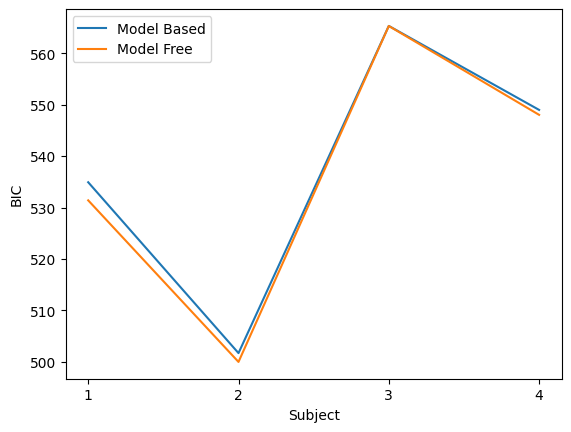

In [46]:
# Compute BIC for each model and subject:
bic_model_based = []
bic_model_free = []
for i in range(len(sub_fns)):
    bic_model_based.append(2 * ll_model_based[i] + len(params) * np.log(trial_count[i]))
    bic_model_free.append(2 * ll_model_free[i] + len(params) * np.log(trial_count[i]))

plt.figure()
plt.plot(bic_model_based[1:], label='Model Based')
plt.plot(bic_model_free[1:], label='Model Free')
plt.xticks(np.arange(4), ['1', '2', '3', '4'])
plt.legend()
plt.xlabel('Subject')
plt.ylabel('BIC')
print(bic_model_based)
print(bic_model_free)

> *model-based leanring and model-free learning are very similar when measured with BIC, but for all the subjects, 
model-free learning's BIC are consistently lower than those of model-based, suggesting former is better*

### Problem 2: Cliff walking

Consider the grid world shown below. This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is -1 on all transitions except those into the region marked “The Cliff.” Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start.

<img src="cliff.png" width="550">  

Two paths are marked: an optimal path which incurs the least costs on the way to the goal, and a roundabout (but safe) path that walks farthest from the cliff.

**Question**: Which algorithm, SARSA or $Q$-learning, would learn either path, and why?

> *SARSA will likely learn the safe path, because it learns the value of the policy it's actually following. SARSA takes into account the actions and subsequent states (and their associated risks) that are actually experienced during training, so falling off the cliff is a priority to be avoided (given the penalty is -100)*  

>*Q-learning would learn the optimal path, because it learns the value of the optimal policy, regardless of the policy being followed. At each step during learning, it is rectified by the best possible outcome afterwards but not the actions that are actually taken.*

**Question**: When behaving according to the softmax of the learned $Q$ values, which path would an agent prefer? (Consider the parameter $β$ and the stability of the environment.) 

> *If $β$ is low, then the softmax function tends to be uniform and thus, not very informative, so the agent would prefer a relatively random path. If $β$ is high, it depends more on the Q values:*  

>*If Q values are learned from Q-learning, then the agent would prefer the optimal path.  
If Q values are learned from SARSA, then the agent would prefer the safe path.*

>*Whether the environment is stable will influence the convergence of Q from limited trainings. An unstable environment will lead both learning to paths in between the safe and optimal ones.*

**Question**: Can you explain why on-policy methods might be superior for learning real-world motor behavior?

> *In real world, the environment is relatively stable (thinking of pysical laws that regulates movements), on-policy methods ensure that the behavior policy align with the target policy, reducing cost from too many explorations.*

#### References

* Daw, N. D., Gershman, S. J., Seymour, B., Dayan, P., & Dolan, R. J. (2011). Model-based influences on humans' choices and striatal prediction errors. *Neuron*, *69*(6), 1204–1215. https://doi.org/10.1016/j.neuron.2011.02.027

* Sutton, R. S., & Barto, A. G. (1992). Reinforcement Learning: An Introduction. MIT Press.